Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in backcompat_fix_rename_lr_to_learning_rate(...):
“the `lr` argument has been renamed to `learning_rate`.”


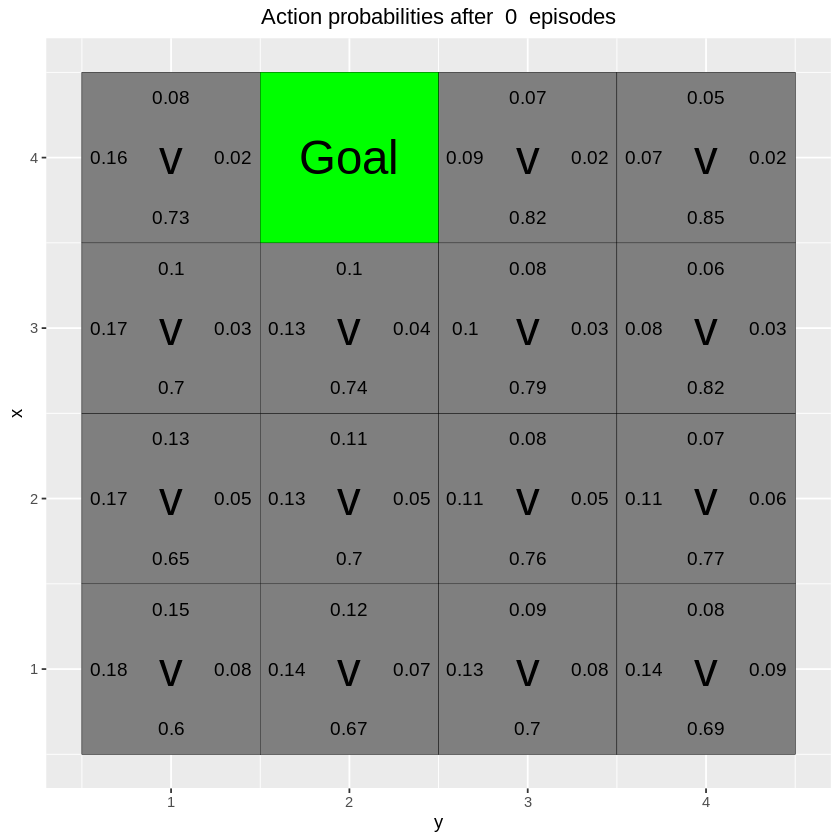

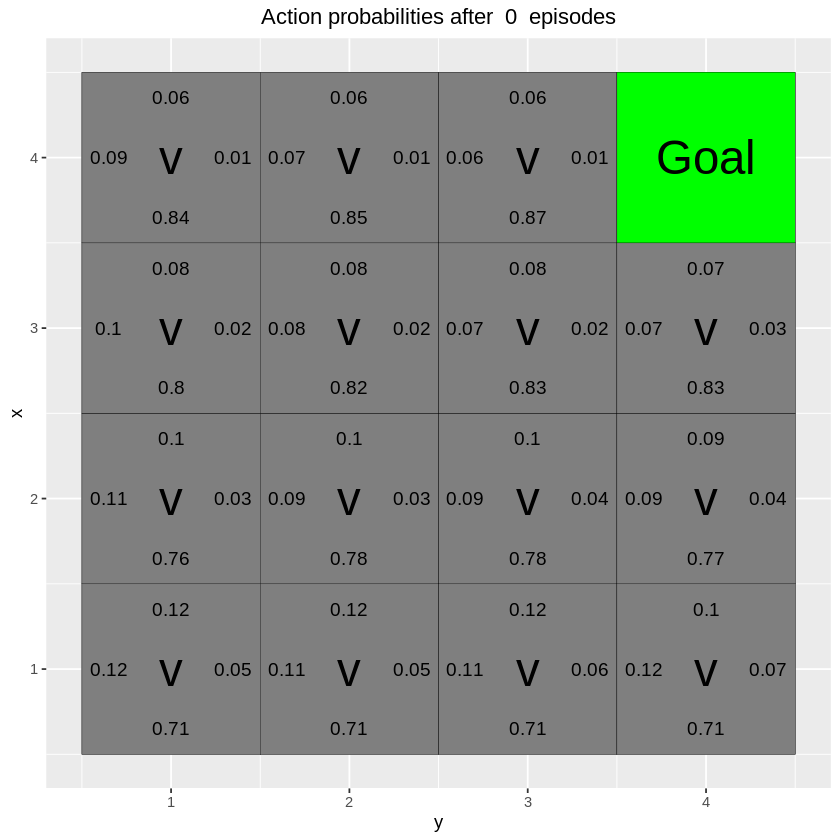

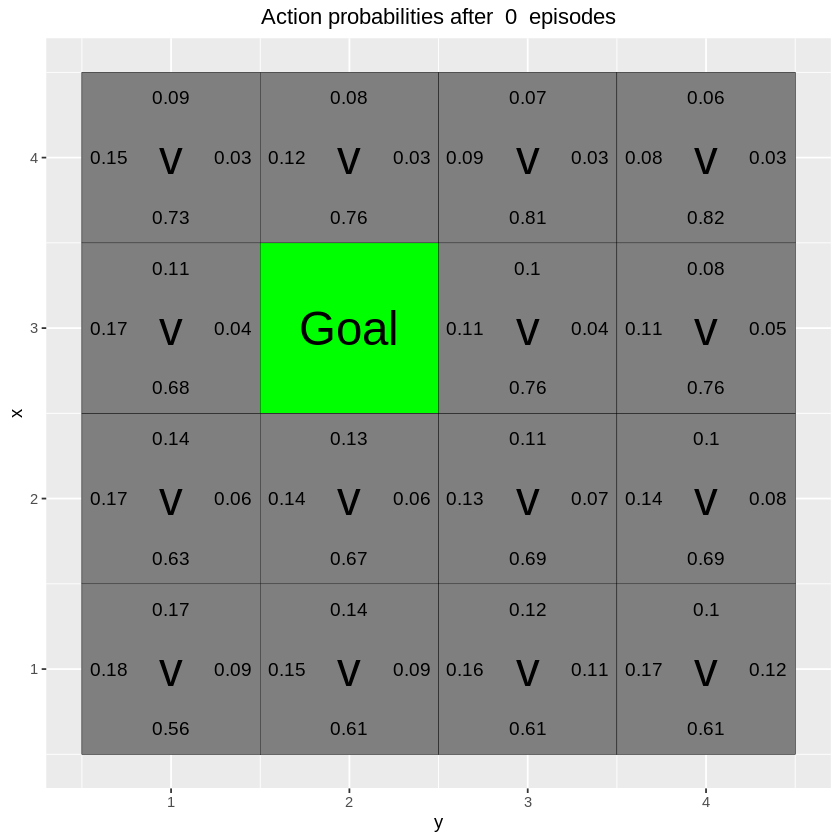

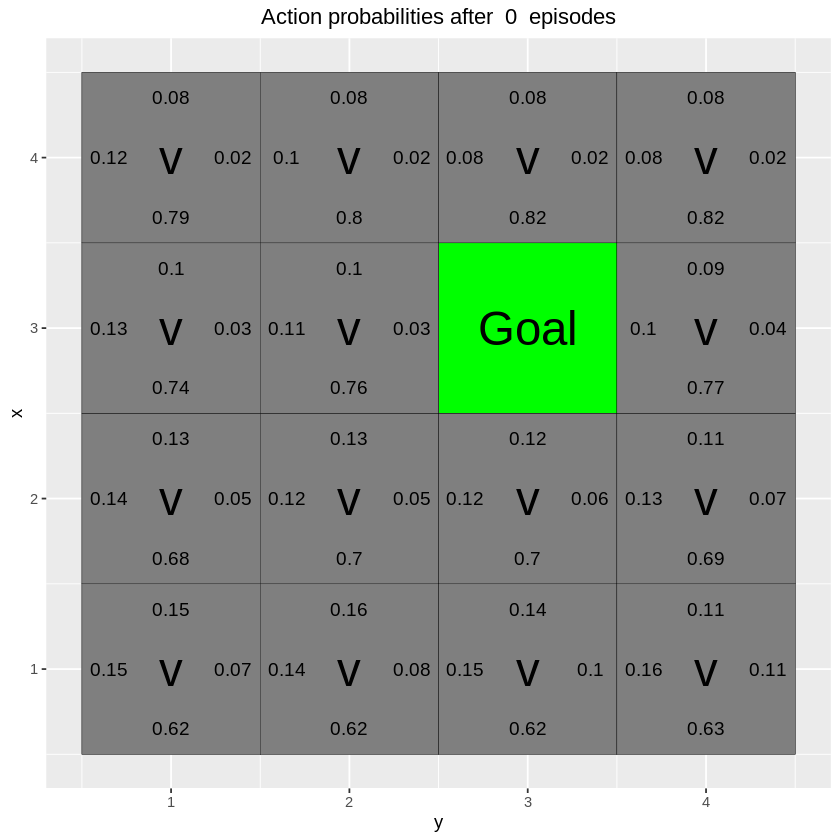

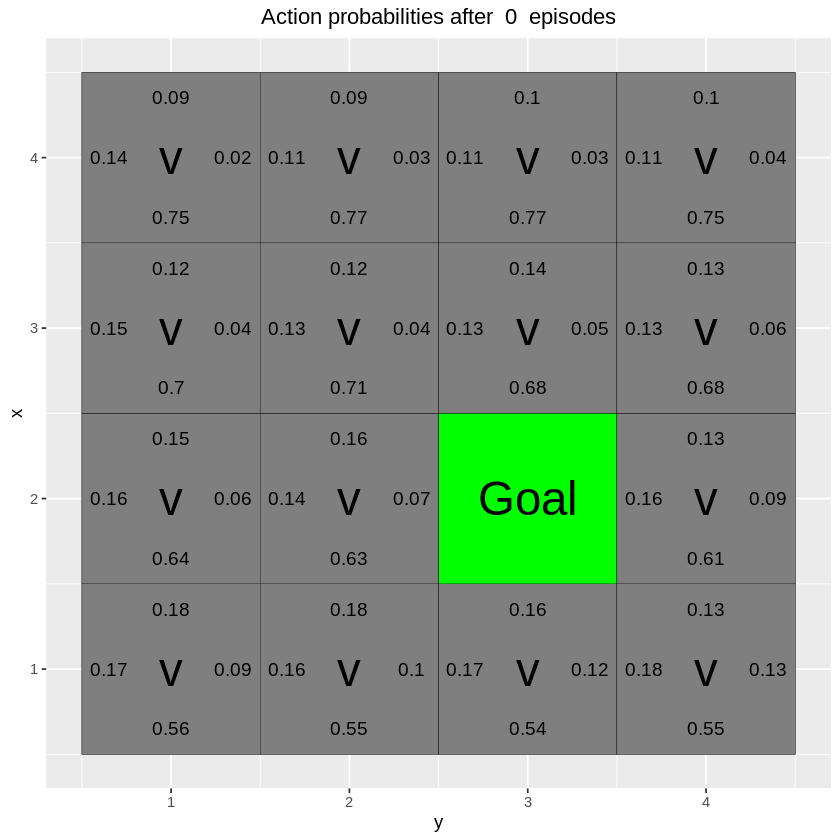

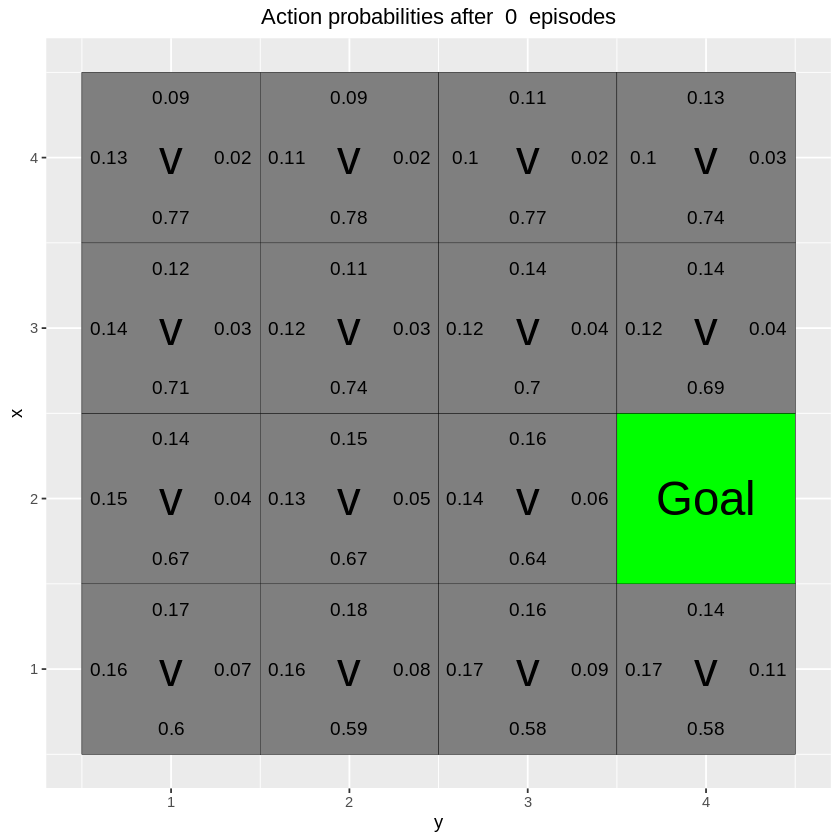

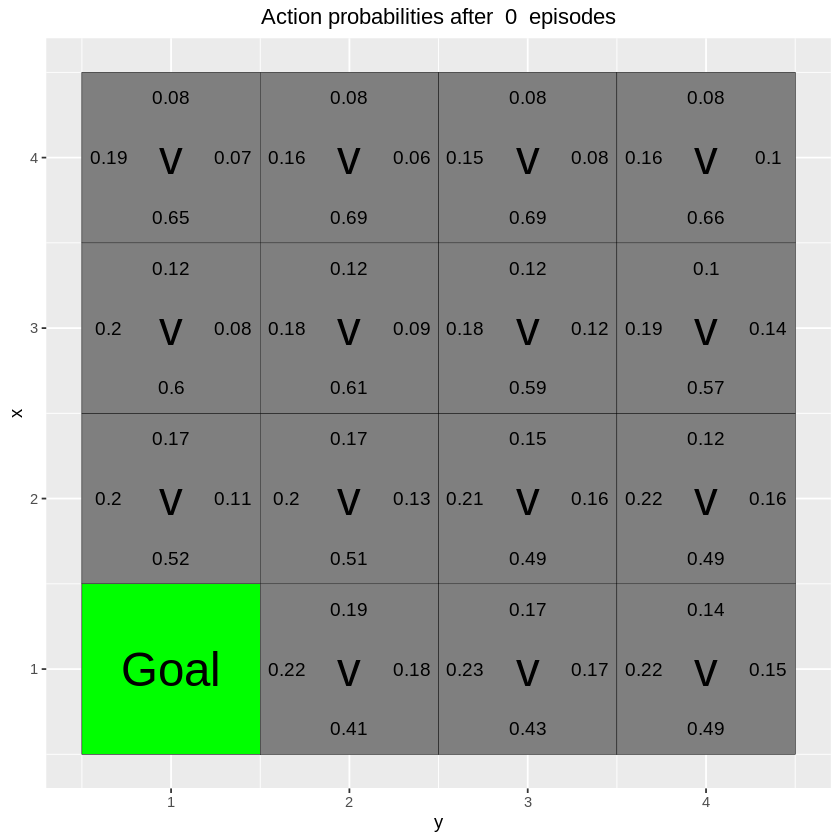

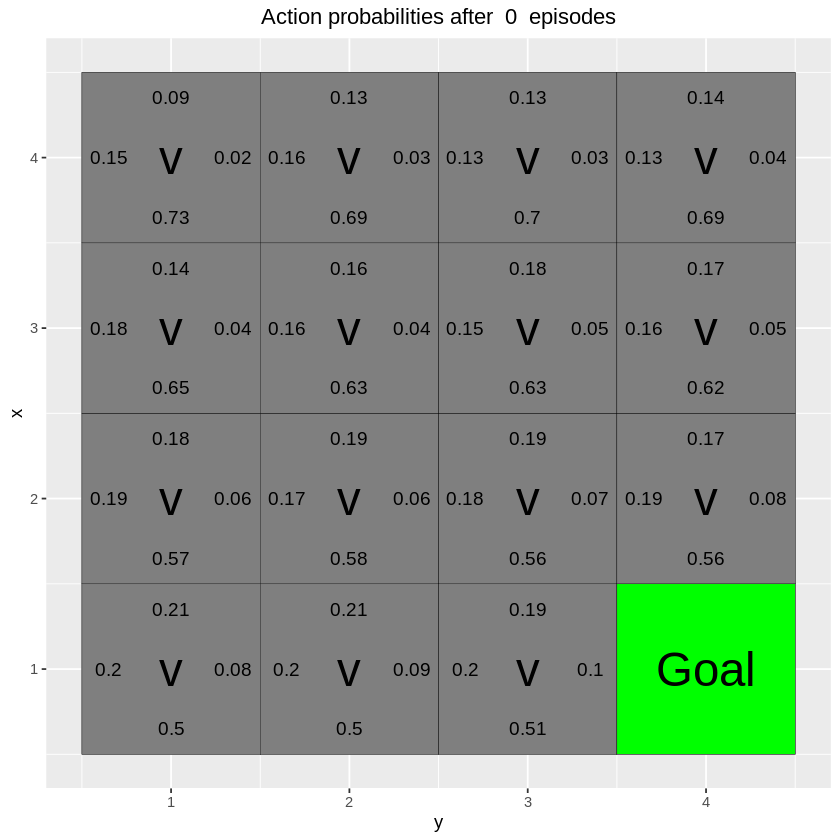

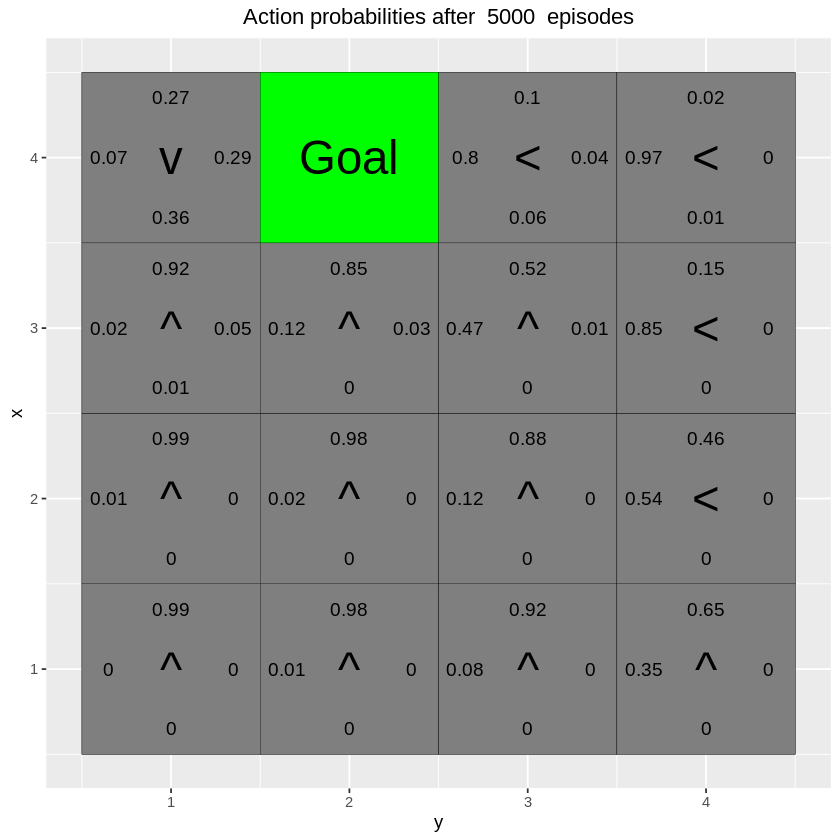

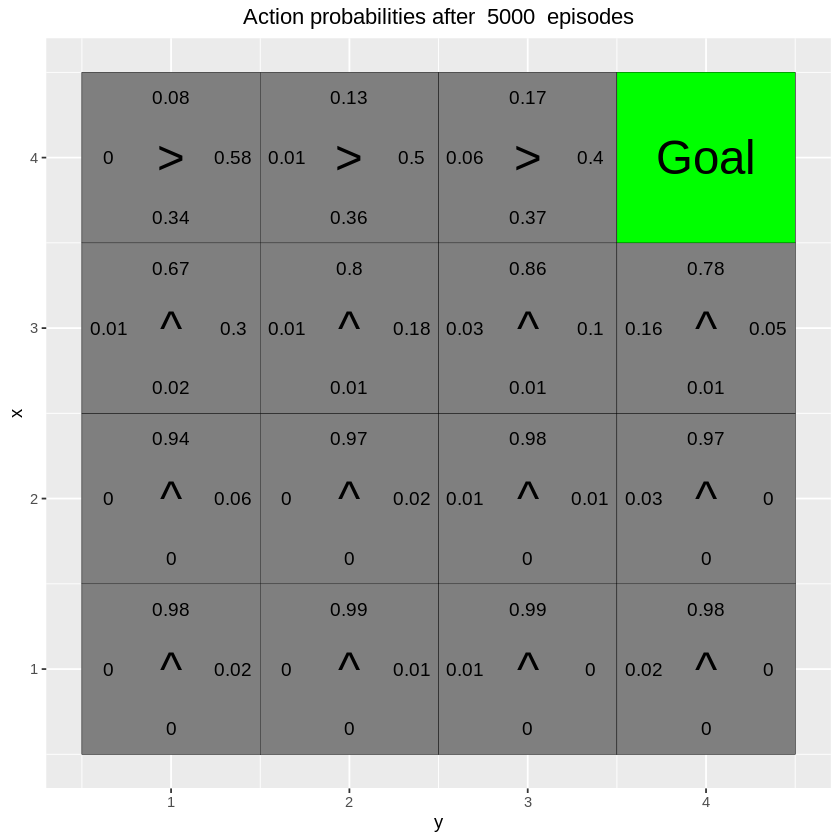

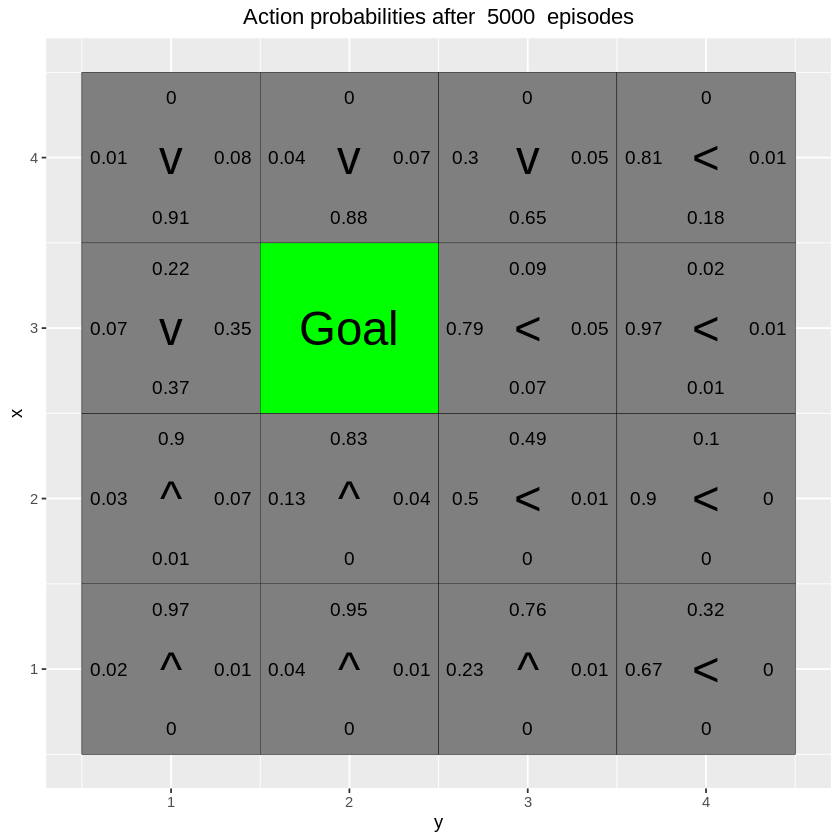

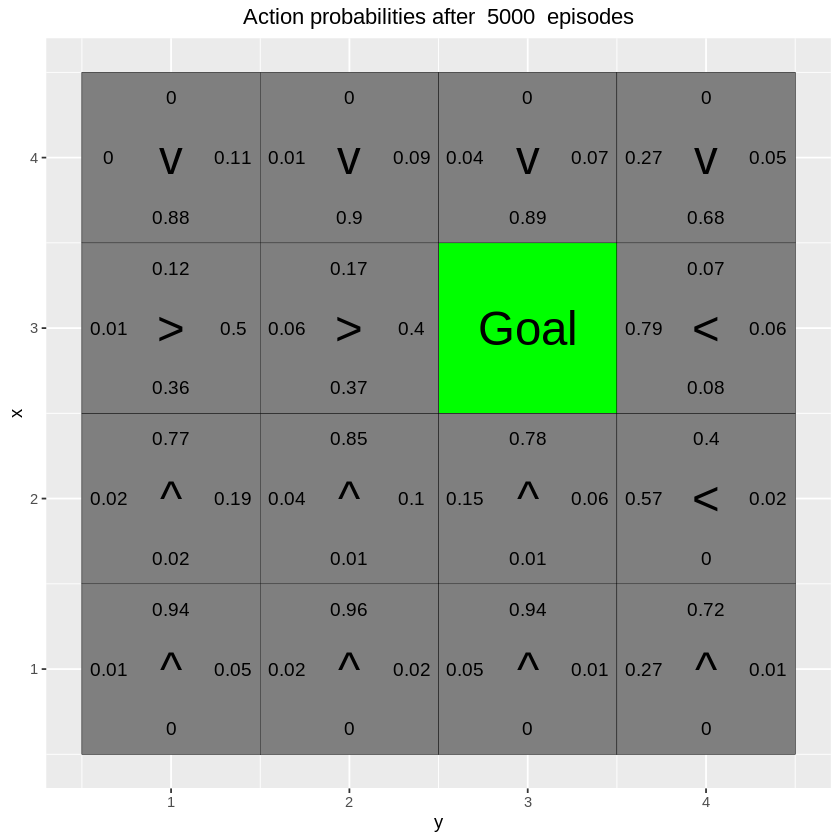

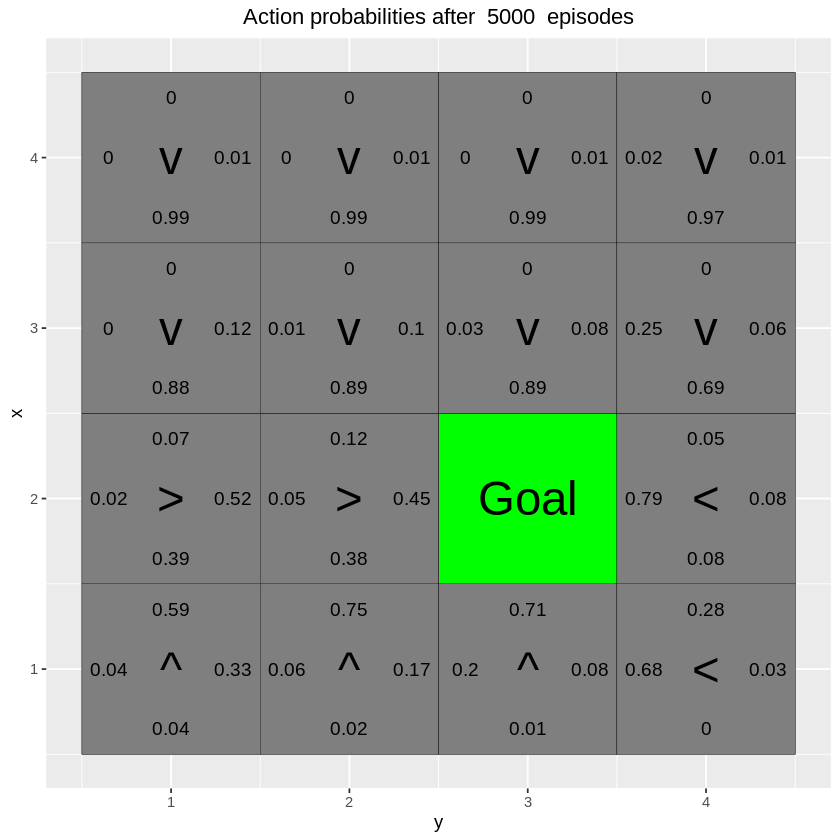

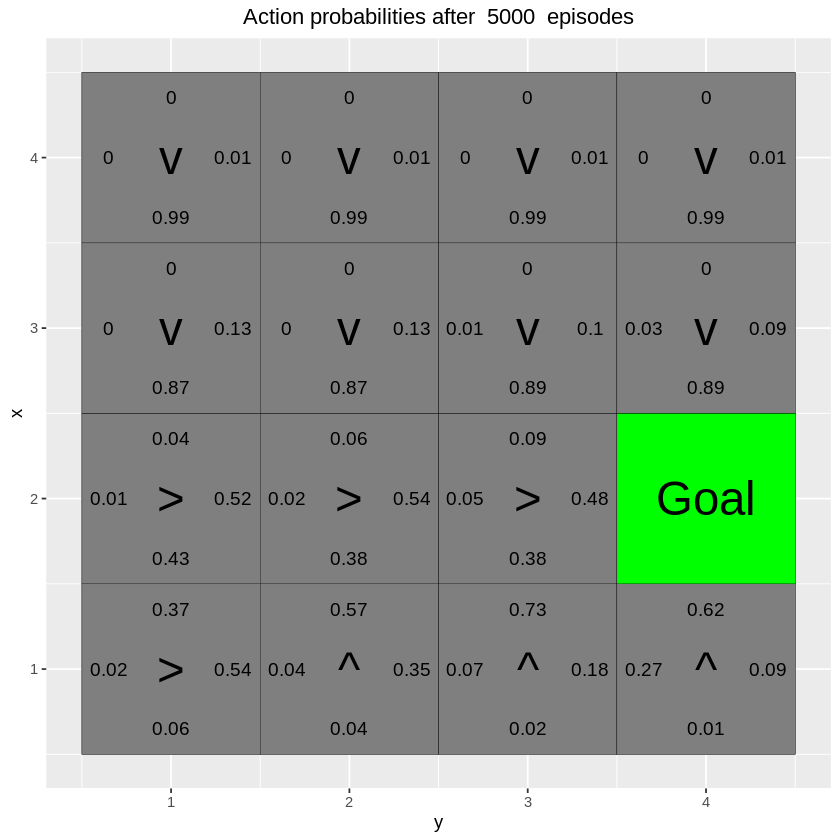

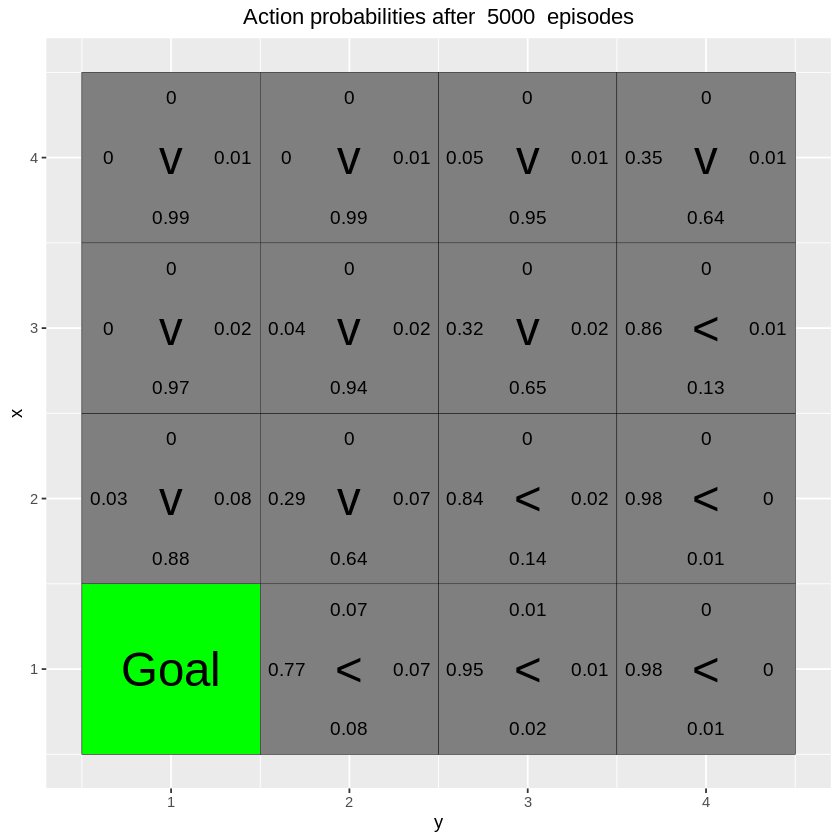

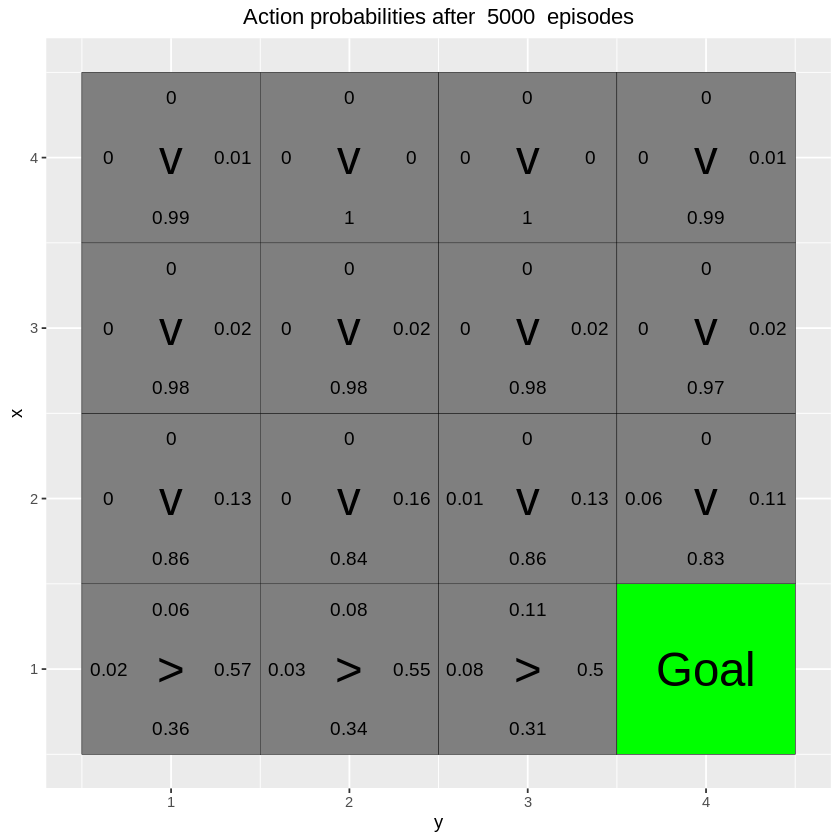

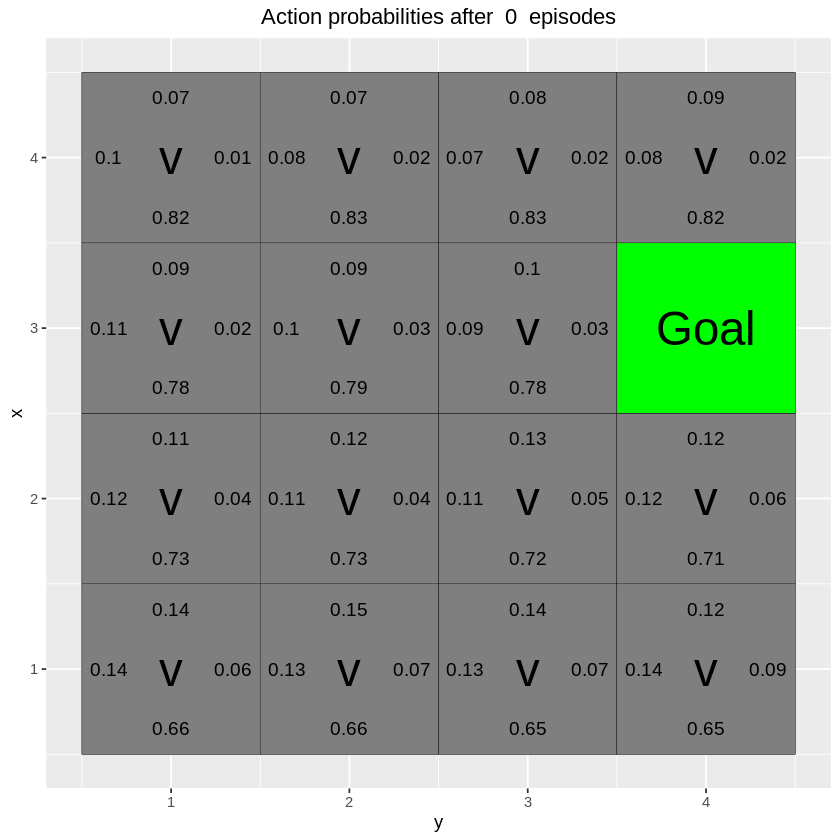

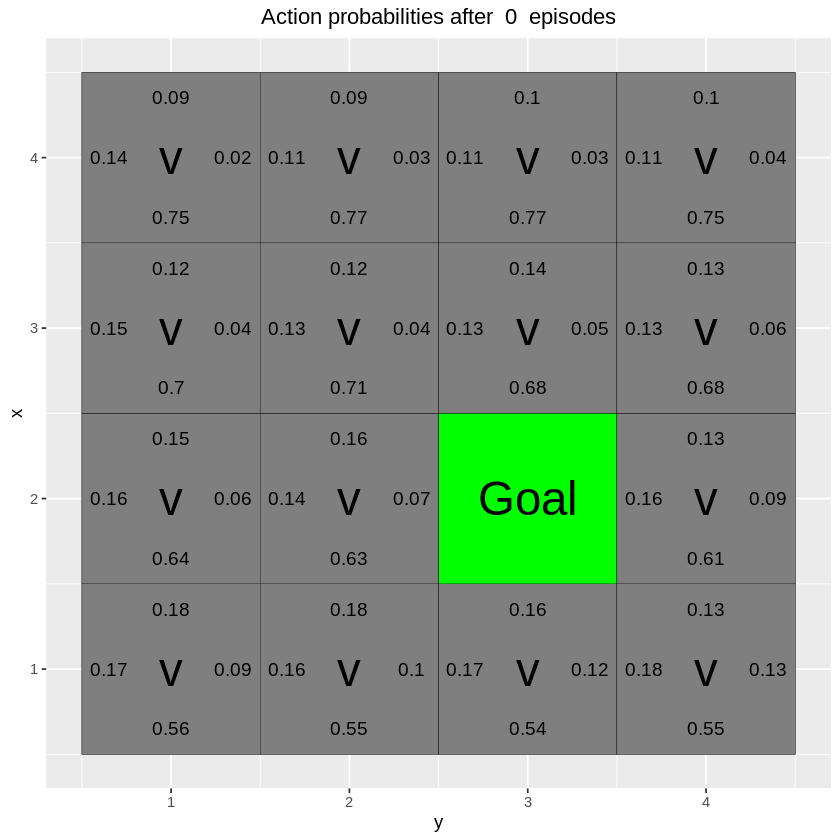

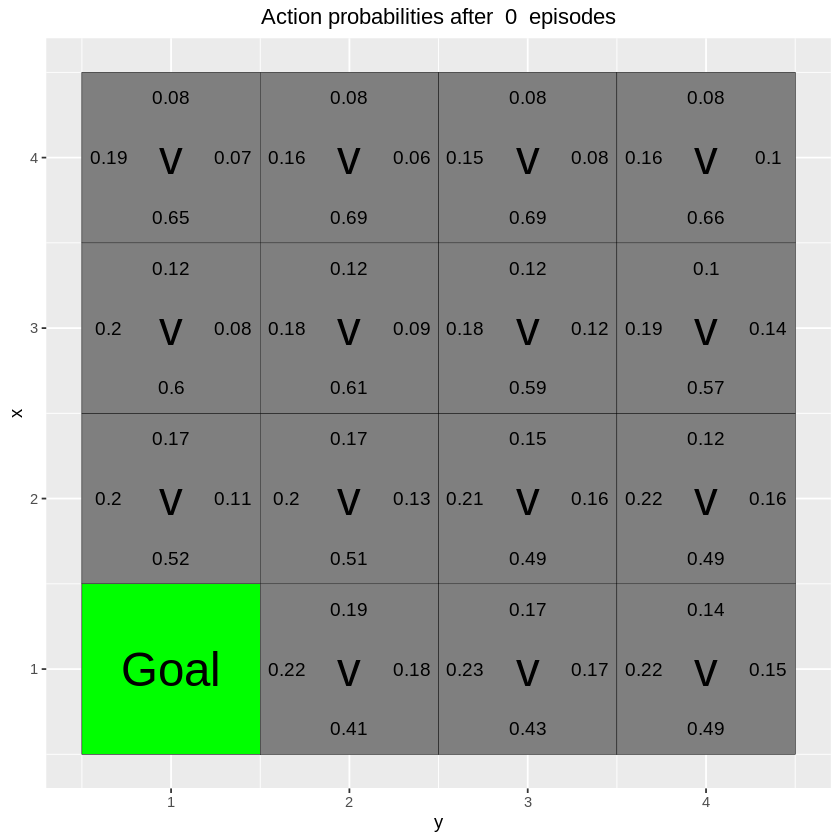

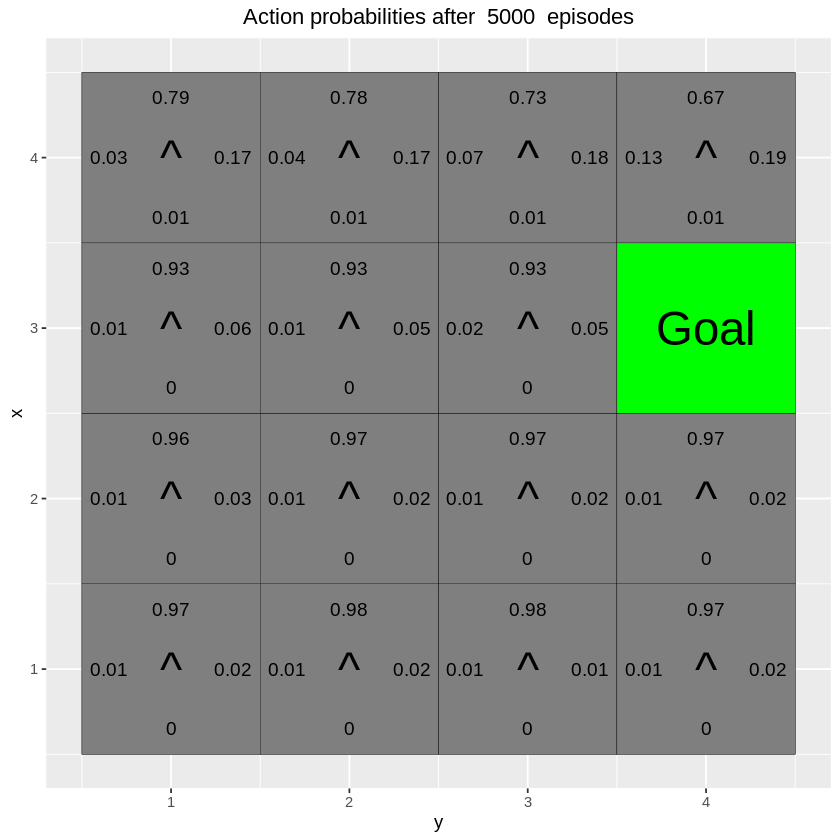

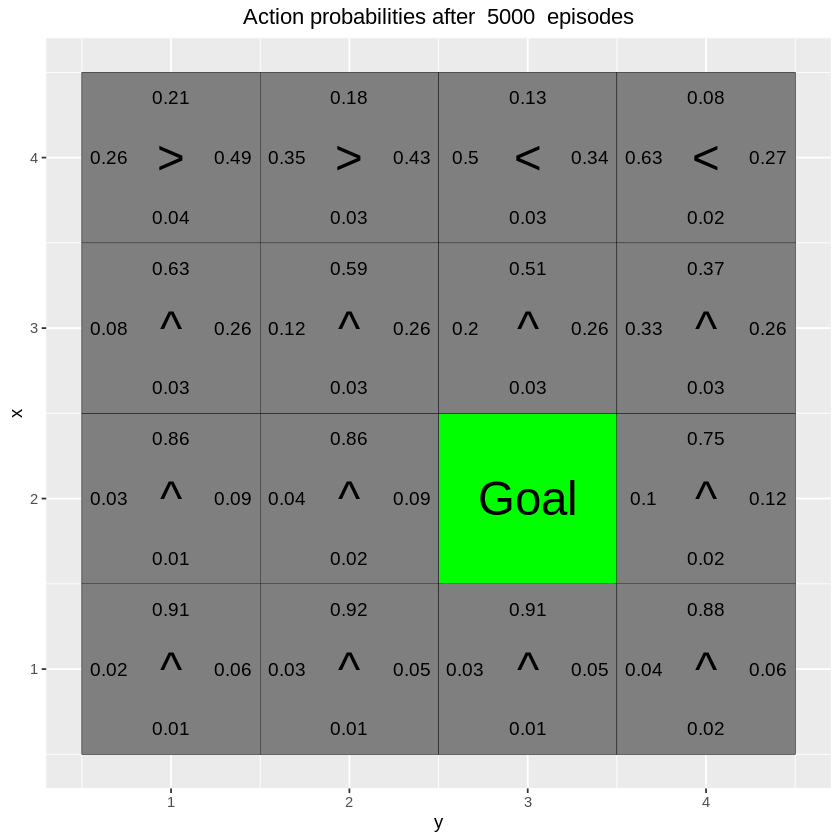

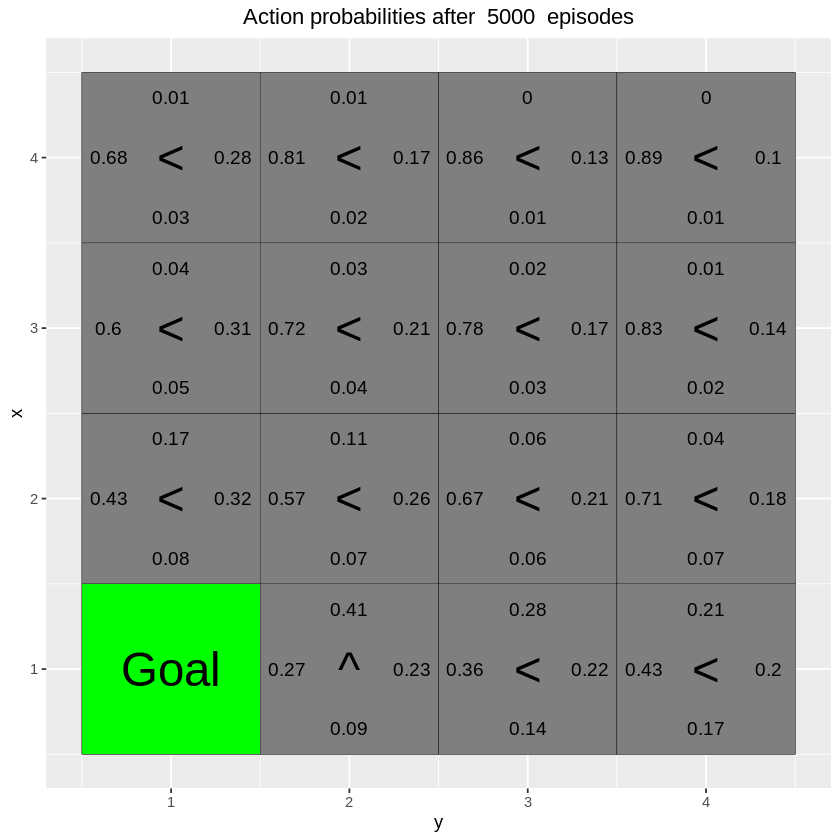

In [7]:
# By Jose M. Peña and Joel Oskarsson.
# For teaching purposes.
# jose.m.pena@liu.se.

#####################################################################################################
# REINFORCE
#####################################################################################################

install.packages("keras")
library(keras)

# install.packages("ggplot2")
# install.packages("vctrs")
library(ggplot2)

arrows <- c("^", ">", "v", "<")
action_deltas <- list(c(1,0), # up
                      c(0,1), # right
                      c(-1,0), # down
                      c(0,-1)) # left

vis_prob <- function(goal, episodes = 0){
  
  # Visualize an environment with rewards. 
  # Probabilities for all actions are displayed on the edges of each tile.
  # The (greedy) policy for each state is also displayed.
  # 
  # Args:
  #   goal: goal coordinates, array with 2 entries.
  #   episodes, epsilon, alpha, gamma, beta (optional): for the figure title.
  #   H, W (global variables): environment dimensions.
  
  df <- expand.grid(x=1:H,y=1:W)
  dist <- array(data = NA, dim = c(H,W,4))
  class <- array(data = NA, dim = c(H,W))
  for(i in 1:H)
    for(j in 1:W){
      dist[i,j,] <- DeepPolicy_dist(i,j,goal[1],goal[2])
      foo <- which(dist[i,j,]==max(dist[i,j,]))
      class[i,j] <- ifelse(length(foo)>1,sample(foo, size = 1),foo)
    }
  
  foo <- mapply(function(x,y) ifelse(all(c(x,y) == goal),NA,dist[x,y,1]),df$x,df$y)
  df$val1 <- as.vector(round(foo, 2))
  foo <- mapply(function(x,y) ifelse(all(c(x,y) == goal),NA,dist[x,y,2]),df$x,df$y)
  df$val2 <- as.vector(round(foo, 2))
  foo <- mapply(function(x,y) ifelse(all(c(x,y) == goal),NA,dist[x,y,3]),df$x,df$y)
  df$val3 <- as.vector(round(foo, 2))
  foo <- mapply(function(x,y) ifelse(all(c(x,y) == goal),NA,dist[x,y,4]),df$x,df$y)
  df$val4 <- as.vector(round(foo, 2))
  foo <- mapply(function(x,y) ifelse(all(c(x,y) == goal),NA,class[x,y]),df$x,df$y)
  df$val5 <- as.vector(arrows[foo])
  foo <- mapply(function(x,y) ifelse(all(c(x,y) == goal),"Goal",NA),df$x,df$y)
  df$val6 <- as.vector(foo)
  
  print(ggplot(df,aes(x = y,y = x)) +
          geom_tile(fill = 'white', colour = 'black') +
          scale_fill_manual(values = c('green')) +
          geom_tile(aes(fill=val6), show.legend = FALSE, colour = 'black') +
          geom_text(aes(label = val1),size = 4,nudge_y = .35,na.rm = TRUE) +
          geom_text(aes(label = val2),size = 4,nudge_x = .35,na.rm = TRUE) +
          geom_text(aes(label = val3),size = 4,nudge_y = -.35,na.rm = TRUE) +
          geom_text(aes(label = val4),size = 4,nudge_x = -.35,na.rm = TRUE) +
          geom_text(aes(label = val5),size = 10,na.rm = TRUE) +
          geom_text(aes(label = val6),size = 10,na.rm = TRUE) +
          ggtitle(paste("Action probabilities after ",episodes," episodes")) +
          theme(plot.title = element_text(hjust = 0.5)) +
          scale_x_continuous(breaks = c(1:W),labels = c(1:W)) +
          scale_y_continuous(breaks = c(1:H),labels = c(1:H)))
  
}

transition_model <- function(x, y, action, beta){
  
  # Computes the new state after given action is taken. The agent will follow the action 
  # with probability (1-beta) and slip to the right or left with probability beta/2 each.
  # 
  # Args:
  #   x, y: state coordinates.
  #   action: which action the agent takes (in {1,2,3,4}).
  #   beta: probability of the agent slipping to the side when trying to move.
  #   H, W (global variables): environment dimensions.
  # 
  # Returns:
  #   The new state after the action has been taken.
  
  delta <- sample(-1:1, size = 1, prob = c(0.5*beta,1-beta,0.5*beta))
  final_action <- ((action + delta + 3) %% 4) + 1
  foo <- c(x,y) + unlist(action_deltas[final_action])
  foo <- pmax(c(1,1),pmin(foo,c(H,W)))
  
  return (foo)
}

DeepPolicy_dist <- function(x, y, goal_x, goal_y){
  
  # Get distribution over actions for state (x,y) and goal (goal_x,goal_y) from the deep policy.
  #
  # Args:
  #   x, y: state coordinates.
  #   goal_x, goal_y: goal coordinates.
  #   model (global variable): NN encoding the policy.
  # 
  # Returns:
  #   A distribution over actions.
  
  foo <- matrix(data = c(x,y,goal_x,goal_y), nrow = 1)
  
  # return (predict_proba(model, x = foo))
  return (predict_on_batch(model, x = foo)) # Faster.
  
}

DeepPolicy <- function(x, y, goal_x, goal_y){
  
  # Get an action for state (x,y) and goal (goal_x,goal_y) from the deep policy.
  #
  # Args:
  #   x, y: state coordinates.
  #   goal_x, goal_y: goal coordinates.
  #   model (global variable): NN encoding the policy.
  # 
  # Returns:
  #   An action, i.e. integer in {1,2,3,4}.
  
  foo <- DeepPolicy_dist(x,y,goal_x,goal_y)
  
  return (sample(1:4, size = 1, prob = foo))
  
}

DeepPolicy_train <- function(states, actions, goal, gamma){
  
  # Train the policy network on a rolled out trajectory.
  # 
  # Args:
  #   states: array of states visited throughout the trajectory.
  #   actions: array of actions taken throughout the trajectory.
  #   goal: goal coordinates, array with 2 entries.
  #   gamma: discount factor.
  
  # Construct batch for training.
  inputs <- matrix(data = states, ncol = 2, byrow = TRUE)
  inputs <- cbind(inputs,rep(goal[1],nrow(inputs)))
  inputs <- cbind(inputs,rep(goal[2],nrow(inputs)))
  
  targets <- array(data = actions, dim = nrow(inputs))
  targets <- to_categorical(targets-1, num_classes = 4)  
  
  # Sample weights. Reward of 5 for reaching the goal.
  weights <- array(data = 5*(gamma^(nrow(inputs)-1)), dim = nrow(inputs))
  
  # Train on batch. Note that this runs a SINGLE gradient update.
  train_on_batch(model, x = inputs, y = targets, sample_weight = weights)
  
}

reinforce_episode <- function(goal, gamma = 0.95, beta = 0){
  
  # Rolls out a trajectory in the environment until the goal is reached.
  # Then trains the policy using the collected states, actions and rewards.
  # 
  # Args:
  #   goal: goal coordinates, array with 2 entries.
  #   gamma (optional): discount factor.
  #   beta (optional): probability of slipping in the transition model.
  
  # Randomize starting position.
  cur_pos <- goal
  while(all(cur_pos == goal))
    cur_pos <- c(sample(1:H, size = 1),sample(1:W, size = 1))
  
  states <- NULL
  actions <- NULL
  
  steps <- 0 # To avoid getting stuck and/or training on unnecessarily long episodes.
  while(steps < 20){
    steps <- steps+1
    
    # Follow policy and execute action.
    action <- DeepPolicy(cur_pos[1], cur_pos[2], goal[1], goal[2])
    new_pos <- transition_model(cur_pos[1], cur_pos[2], action, beta)
    
    # Store states and actions.
    states <- c(states,cur_pos)
    actions <- c(actions,action)
    cur_pos <- new_pos
    
    if(all(new_pos == goal)){
      # Train network.
      DeepPolicy_train(states,actions,goal,gamma)
      break
    }
  }
  
}

#####################################################################################################
# REINFORCE Environments
#####################################################################################################

# Environment D (training with random goal positions)

H <- 4
W <- 4

# Define the neural network (two hidden layers of 32 units each).
model <- keras_model_sequential()
model %>% 
  layer_dense(units = 32, input_shape = c(4), activation = 'relu') %>% 
  layer_dense(units = 32, activation = 'relu') %>% 
  layer_dense(units = 4, activation = 'softmax')

compile(model, loss = "categorical_crossentropy", optimizer = optimizer_sgd(lr=0.001))

initial_weights <- get_weights(model)

train_goals <- list(c(4,1), c(4,3), c(3,1), c(3,4), c(2,1), c(2,2), c(1,2), c(1,3))
val_goals <- list(c(4,2), c(4,4), c(3,2), c(3,3), c(2,3), c(2,4), c(1,1), c(1,4))

show_validation <- function(episodes){
  
  for(goal in val_goals)
    vis_prob(goal, episodes)
  
}

set_weights(model,initial_weights)

show_validation(0)

for(i in 1:5000){
  # if(i%%10==0) cat("episode",i,"\n")
  goal <- sample(train_goals, size = 1)
  reinforce_episode(unlist(goal))
}

show_validation(5000) 

# Environment E (training with top row goal positions)

train_goals <- list(c(4,1), c(4,2), c(4,3), c(4,4))
val_goals <- list(c(3,4), c(2,3), c(1,1))

set_weights(model,initial_weights)

show_validation(0)

for(i in 1:5000){
  # if(i%%10==0) cat("episode", i,"\n")
  goal <- sample(train_goals, size = 1)
  reinforce_episode(unlist(goal))
}

show_validation(5000)